#### Импорты

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#### Теория

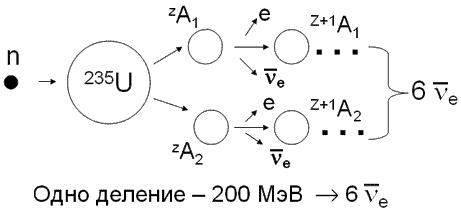  

<a href="http://nuclphys.sinp.msu.ru/neutrino_astr/na3.htm" target="_blank">Здесь</a> написано, что cреднее число β-распадов, испытываемых осколками, равно 6.  

Закон радиоактивного распада:  
$N = N_0 e^{-\lambda t} \\ 
\frac{dN}{dt} = -\lambda N$

Масса одной таблетки:  
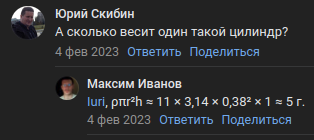

$Постоянная \ распада \ для \ U^{235}: 9.8*10^{10} \ год^{-1}$

#### Спектр

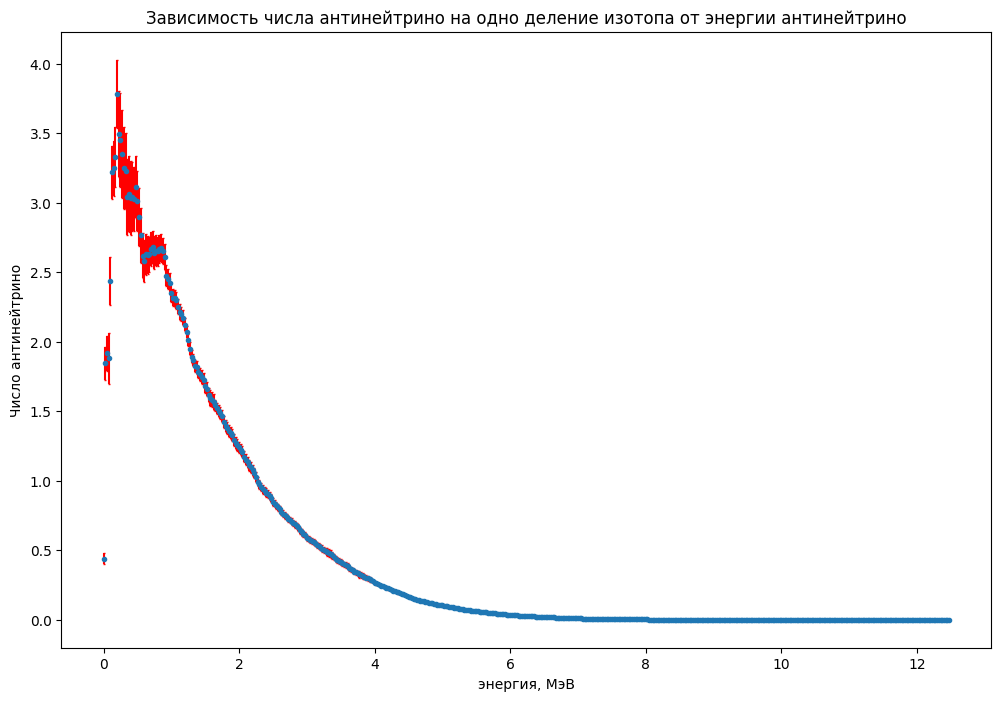

In [2]:
file = uproot.open("BESTIOLE_amp_Fallot_Spectra.root")
key = "235-Best;1"
x = file[key].axis().edges()[:-1]
y = file[key].values()
err = file[key].errors()
plt.figure(figsize=(12, 8))
plt.errorbar(x, y, err, ecolor="r", fmt='.', capsize=1)
plt.title("Зависимость числа антинейтрино на одно деление изотопа от энергии антинейтрино")
plt.xlabel("энергия, МэВ")
plt.ylabel("Число антинейтрино")
plt.show()

#### Функции

In [3]:
def binary_search(list, key): # бинарный поиск
    low = 0
    high = len(list) - 1

    while low <= high:
        mid = (low + high) // 2
        midVal = list[mid]
        if midVal == key:
            return mid
        if midVal > key:
            high = mid - 1
        else:
            low = mid + 1
    return mid


def linear_interpolation(energy, x,  y): # линейная интерполяция
    ind = binary_search(x, energy)
    if energy > x[ind]:
        ind += 1
    k = (y[ind] - y[ind - 1]) / (x[ind] - x[ind - 1])
    b = y[ind] - k * x[ind]
    return k * energy + b

#### Классы

In [4]:
class Tablet():

    def __init__(self, coord, fission_count, activity, mu, m):
        self.t_coord = coord[:] # координаты таблетки
        self.fission_count = fission_count # активность изотопа
        self.activity = activity # активность изотопа в год-1
        self.mu = mu # молярная масса изотопа в кг / моль
        self.m = m # масса изотопа в таблетке в кг (почему бы и нет)

    
    def get_flux_in_point(self, coord, energy, x, y): # x, y - данные из спектра, coord - координаты таблетки
        area = 4 * np.pi * sum([(coord[i] - self.t_coord[i]) ** 2 for i in range(len(coord))])
        s = linear_interpolation(energy, x, y)
        return s / area * self.fission_count
    

    def get_neutrino_count_in_point(self, coord, energy, x, y, t): # t - время измерения
        flux = self.get_flux_in_point(coord, energy, x, y)
        Na = 6.022 * 1e23 # постоянная Авогадро
        N = Na * self.m / self.mu * (1 - np.exp(-self.activity * t)) # число распадов за время измерений
        return N * flux


class Reactor():

    def __init__(self, params):
        self.R = params["R"] # радиус и высота реактора
        self.l = params["l"] # число слоёв в реакторе
        self.n = params["n"] # число диагоналей
        self.k = params["k"] # число таблеток на радиусе 
        eps = 1e-10 # эпсилон
        dr = self.R / self.n # расстояние между таблетками на радиусах
        dphi = np.pi / self.n # шаг угла
        dz = self.R / (self.l - 1) # шаг высоты
        self.tablets = [Tablet((r * np.cos(phi), r * np.sin(phi), z), 6, 9.8 * 1e10, 0.235, 0.005) for r in np.arange(dr, self.R + eps, dr)\
                                                                         for phi in np.arange(0, 2 * np.pi, dphi)\
                                                                         for z in np.arange(-self.R / 2, self.R / 2 + eps, dz)]
        
    
    def flux(self, coord, energy, x, y): # поток
        result_flux = sum([tablet.get_flux_in_point(coord, energy, x, y) for tablet in self.tablets])
        return result_flux
    

    def neutrino_count(self, coord, energy, x, y, t):
        result_count = sum([tablet.get_neutrino_count_in_point(coord, energy, x, y, t) for tablet in self.tablets])
        return result_count

    
    def show(self): # красота
        x = [el.t_coord[0] for el in self.tablets]
        y = [el.t_coord[1] for el in self.tablets]
        z = [el.t_coord[2] for el in self.tablets]
        fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
        fig.show()

#### Пример работы программы

In [5]:
R = 1.5
l = 3
n = 4
k = 4
params = {"R": R, "l": l, "n": n, "k": k}
reactor = Reactor(params)

coord = (7, 7, 7) # координаты заданы в метрах
energy = 0.5 # энергия задана в МэВ
t = 1 / 365
flux = reactor.flux(coord, energy, x, y)
neutrino_count = reactor.neutrino_count(coord, energy, x, y, t)
print(f"Поток антинейтрино в точке {coord}: {flux}")
print(f"Число антинейтрино в единице площади, прошедших за 1 день, через детектор: {neutrino_count}")

Поток антинейтрино в точке (7, 7, 7): 0.9427571160608559
Число антинейтрино в единице площади, прошедших за 1 день, через детектор: 1.207932628280526e+22


In [6]:
reactor.show()